Here we will implement an expression class for representing Real valued functions that take vectors as inputs.

In [20]:
import numpy as np

# Node Classes

# Base Expression
# the _b at the end means it supports backward mode
class Expression:
    def __init__(self):
        self.partial = 0
        self.value = 0

    def __str__():
        return "EXPRESSION" 

    def eval(self):
        self.partial = 0
        return "CANT EVALUATE BASE EXPRESSION CLASS"

    def derive():
        return "CANT DERIVE OF BASE EXPRESSION CLASS"

# Base Expression Types
    
class Un_Op(Expression):
    def __init__(self, a):
        Expression.__init__(self)
        self.a = a
    def __str__(self):
        return "[UNARY OP]"
    def reset_partial(self):
        self.partial = np.zeros(self.value.shape)
        self.a.reset_partial()

class Bi_Op(Expression):
    def __init__(self, a, b):
        Expression.__init__(self)
        self.a = a
        self.b = b
    def __str__(self):
        return "[BINARY OP]"
    def reset_partial(self):
        self.partial = np.zeros(self.value.shape)
        self.a.reset_partial()
        self.b.reset_partial()
    
# Usable Expression Types

# Constants
class Const(Un_Op):
    def __str__(self):
        return str(self.a)
    
    def eval(self):
        self.value = self.a
        return self.a
    def derive(self):
        return 0
    
class VConst(Un_Op):
    def __str__(self):
        return str(self.a)
    
    def eval(self):
        self.value = self.a
        return self.a
    def derive(self):
        return np.zeros(self.a.shape)

# Variables  
class Var(Expression):
    def __init__(self, name, value = None):
        '''
        name  : typeof(string)
        value : typeof(float)
        '''
        self.name = name
        self.value = value
        self.partial = 0
    def __str__(self):
        return self.name
    def eval(self):
        return self.value
    def derive(self):
        return 1
    def reset_partial(self):
        self.partial = np.zeros(self.value.shape)
    
# Unary Operations
class Sum(Un_Op):
    def __str__(self):
        return f"Sum({str(self.a)})"
    def eval(self):
        self.value = np.sum(self.a.eval())
        return self.value
    def derive(self):
        dthis_da = np.ones(self.a.value.shape)
        self.a.partial += dthis_da * self.partial
        self.a.derive()
        return
    
class Sin(Un_Op):
    def __str__(self):
        return f"sin({str(self.a)})"
    def eval(self):
        self.value = np.sin(self.a.eval())
        return self.value
    def derive(self):
        dthis_da = np.cos(self.a.value)
        self.a.partial += dthis_da * self.partial # check if this is elementwise for np arrays
        self.a.derive()
        return

class Exp(Un_Op):
    def __str__(self):
        return f"exp({str(self.a)})"
    def eval(self):
        self.value = np.exp(self.a.eval())
        return self.value
    def derive(self):
        dthis_da = np.exp(self.a.value)
        self.a.partial += dthis_da * self.partial # check if this is elementwise for np arrays
        self.a.derive()
        return
    
class Sigmoid(Un_Op):
    def __str__(self):
        return f"Sig({str(self.a)})"
    def eval(self):
        self.value = (1 / (1 + np.exp(- self.a.eval())))
        return self.value
    def derive(self):
        sig_a = 1 / (1 + np.exp(-self.a.value))
        dthis_da = sig_a * (1 - sig_a)
        self.a.partial += dthis_da * self.partial
        self.a.derive()
        return
    
class ReLU(Un_Op):
    def __str__(self):
        return f"ReLU({str(self.a)})"
    def eval(self):
        self.value = np.maximum(0, self.a.eval())
        return self.value
    def derive(self):
        dthis_da = np.array(self.a.value > 0, np.float32)
        self.a.partial += dthis_da * self.partial
        self.a.derive()
        return

# Binary Operations
class VIdx(Bi_Op):
    def __str__(self):
        return f"{str(self.a)}[{str(self.b)}]"
    def eval(self):
        self.value = self.a.eval()[self.b]
        return self.value
    def derive(self):
        dthis_da = np.zeros(self.a.value.shape)
        dthis_da[self.b] = 1
        self.a.partial += dthis_da * self.partial
        self.a.derive()
        return

class Add(Bi_Op):
    def __str__(self):
        return f"({str(self.a)} + {str(self.b)})"
    def eval(self):
        self.value = self.a.eval() + self.b.eval()
        return self.value   
    def derive(self):
        self.a.partial += self.partial # check if this is elementwise for np arrays
        self.b.partial += self.partial # check if this is elementwise for np arrays
        self.a.derive()
        self.b.derive()   

class Sub(Bi_Op):
    def __str__(self):
        return f"({str(self.a)} - {str(self.b)})"
    def eval(self):
        self.value = self.a.eval() - self.b.eval()
        return self.value   
    def derive(self):
        self.a.partial += self.partial # check if this is elementwise for np arrays
        self.b.partial -= self.partial # check if this is elementwise for np arrays
        self.a.derive()
        self.b.derive()   

class Mult(Bi_Op):
    '''
    Multiples:
        vectors * vectors (elementwise),
        scalars * scalars,
        vectors * scalars, or
        scalars * vectors
    '''
    def __str__(self):
        return f"({str(self.a)} + {str(self.b)})"
    def eval(self):
        self.value = self.a.eval() + self.b.eval()
        return self.value   
    def derive(self):
        dthis_da = self.b.value 
        dthis_db = self.a.value
        self.a.partial += dthis_da * self.partial
        self.b.partial += dthis_db * self.partial
        self.a.derive()
        self.b.derive()  

class PowInt(Bi_Op):
    def __str__(self):
        return f"({str(self.a)} ^ {str(self.b)})"
    def reset_partial(self):
        self.partial = np.zeros(self.value.shape)
        self.a.reset_partial()
    def eval(self):
        self.value = np.power(self.a.eval(),  self.b)
        return self.value   
    def derive(self):
        dthis_da = self.b * np.power(self.a.value, (self.b - 1))
        self.a.partial += dthis_da * self.partial
        self.a.derive()
    
class MVMult(Bi_Op):
    def __str__(self):
        return f"({str(self.a)} @ {str(self.b)})"  
    def eval(self):
        self.value = np.matmul(self.a.eval(), self.b.eval())
        return self.value
    def derive(self):
        dthis_da = np.transpose(np.array([self.b.value]))
        dthis_db = np.transpose(self.a.value)
        self.a.partial += np.array([self.partial]).T @ dthis_da.T # no sure why i need to transpose the partial, will need to work through the linear algebra again on paper
        self.b.partial += dthis_db @ self.partial
        self.a.derive()
        self.b.derive()   

In [21]:
# code that we want to work
A = Var("A", np.array([[2 ,-2],[1,0]]))
x = Var("x", np.array([1 + 0.001/0.61350112, 0.5]))
b = Var("y", np.array([1,0.5])) # note this is disgusting syntax, the fact we have to define vectors differently for addition and matrix multiplication

func = Sum(PowInt(Sigmoid(Add(MVMult(A, x), b)), 2))
        
print("f(x) =", func.eval())

func.partial = 1

func.derive()

print("df/dA =\n", A.partial)
print("df/dx =\n", x.partial)
print("df/db =\n", b.partial)

print(A.value.shape)
print(x.value.shape)
print(b.value.shape)

# this code does seem to work when manually checking agains finite differences

f(x) = 1.4452312077201455
df/dA =
 [[0.1848697  0.09228443]
 [0.24409384 0.12184831]]
df/dx =
 [ 0.61283432 -0.3691377 ]
df/db =
 [0.18456885 0.24369662]
(2, 2)
(2,)
(2,)


In [22]:
def printVars(vars):
    for v in vars:
        print(v.name, "=")
        print("value :", v.value)
        print("partial : ", v.partial)

Sig(ReLU(((W_12 @ ReLU(((W_01 @ x) + b_1))) + b_2)))
Sum(((Sig(ReLU(((W_12 @ ReLU(((W_01 @ x) + b_1))) + b_2))) - y) ^ 2))
[0.5]
[array([0.5171147]), array([0.5]), array([0.5]), array([0.5]), array([0.5]), array([0.50610618]), array([0.5]), array([0.5]), array([0.5]), array([0.5]), array([0.51558584]), array([0.50156462]), array([0.5]), array([0.5]), array([0.59503194]), array([0.51521946]), array([0.5]), array([0.5]), array([0.54586677]), array([0.57222186]), array([0.5]), array([0.558871]), array([0.5303194]), array([0.5]), array([0.55643391]), array([0.5]), array([0.5]), array([0.5]), array([0.53439628]), array([0.5]), array([0.5]), array([0.5]), array([0.5]), array([0.55143367]), array([0.56064526]), array([0.50945944]), array([0.5]), array([0.5]), array([0.50127955]), array([0.5]), array([0.50211345]), array([0.60211382]), array([0.51051219]), array([0.54188192]), array([0.5]), array([0.5047024]), array([0.54197192]), array([0.59837448]), array([0.5]), array([0.54544271]), array([

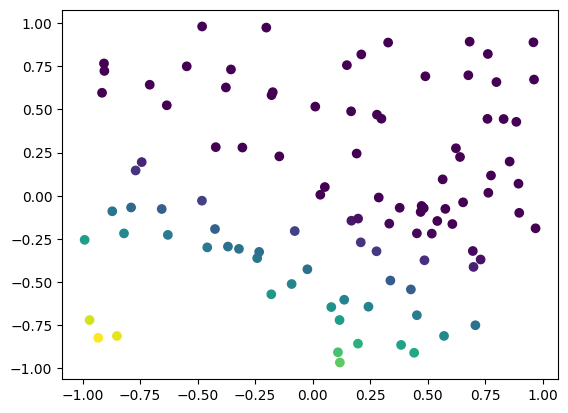

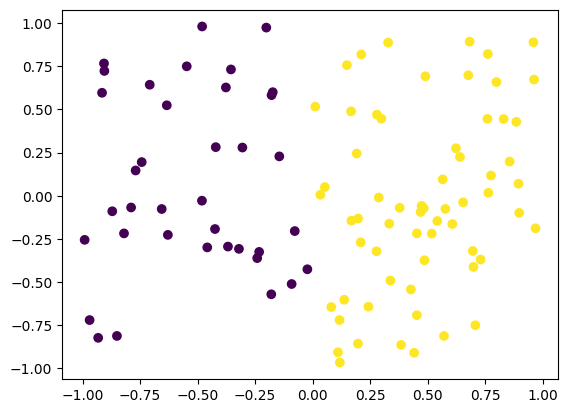

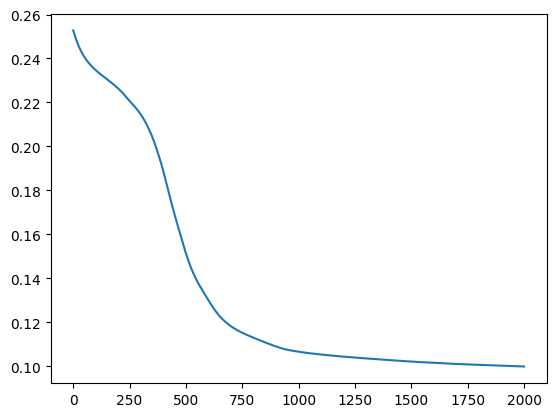

[array([0.9337276]), array([0.994804]), array([0.75181322]), array([0.5]), array([0.5]), array([0.87782819]), array([0.98323265]), array([0.98394933]), array([0.99721432]), array([0.5]), array([0.5]), array([0.95687013]), array([0.99022627]), array([0.98986822]), array([0.5]), array([0.89994132]), array([0.99678346]), array([0.90244355]), array([0.82486248]), array([0.7728371]), array([0.99264338]), array([0.95840189]), array([0.5]), array([0.99606702]), array([0.79523574]), array([0.998042]), array([0.5]), array([0.904597]), array([0.5]), array([0.98588801]), array([0.5]), array([0.98789424]), array([0.98757965]), array([0.7582135]), array([0.97088973]), array([0.99519368]), array([0.77969719]), array([0.99006309]), array([0.98723218]), array([0.97431379]), array([0.99477374]), array([0.5]), array([0.5]), array([0.5]), array([0.99443625]), array([0.99560371]), array([0.5]), array([0.5]), array([0.5]), array([0.90531008]), array([0.99558631]), array([0.94466517]), array([0.94546371]), 

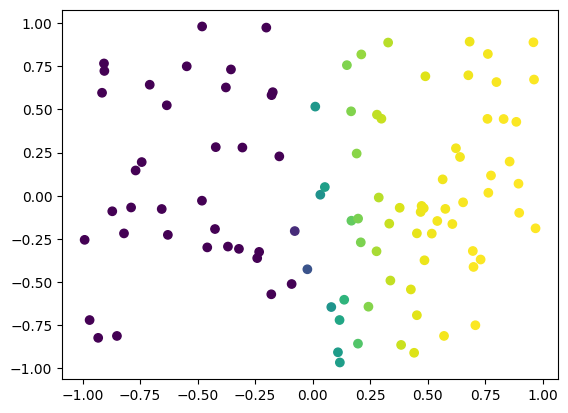

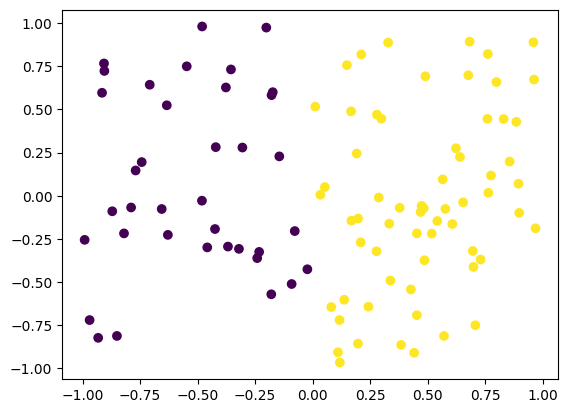

In [43]:
import matplotlib.pyplot as plt

# Hardcoded feedforward NN example
# our nn architecture:
#
#
# R^l0      R^l1            R^l2            R^l3
# x -> activation_1 -> activation_2 -> outputs
# f(x) = s(W_23 @ s(W_12 @ s(W_01 @ inputs + b_1) + b_2) + b_3)

layerSizes = [2, 2, 1]

x = Var("x", np.ones([layerSizes[0]]))

W_01 = Var("W_01", np.random.normal(0, 1/layerSizes[0], [layerSizes[1], layerSizes[0]]))
W_12 = Var("W_12", np.random.normal(0, 1/layerSizes[1], [layerSizes[2], layerSizes[1]]))
W = [W_01, W_12]

b_1 = Var("b_1", np.zeros([layerSizes[1]]))
b_2 = Var("b_2", np.zeros([layerSizes[2]]))
b = [b_1, b_2]

variables = W + b # list of all variable objects, needed for resetting their partials for repeated evaluation

y_desired = Var("y", np.array([0]))
output = Sigmoid(ReLU(Add(MVMult(W_12, ReLU(Add(MVMult(W_01, x), b_1))), b_2)))
cost = Sum(PowInt(Sub(output, y_desired), 2))

print(output)
print(cost)

print(output.eval())

#generate synthetic data
n_train = 100
x_train = [np.random.uniform(-1,1,x.value.shape) for n in range(n_train)]
y_train = [np.array([(np.sign(x_train[n][0]) + 1) / 2]) for n in range(n_train)]

def showResult():
    outputs = []

    for x_t in x_train:
        x.value = x_t
        outputs.append(output.eval())

    print(outputs)

    plt.scatter([x_t[0] for x_t in x_train], [x_t[1] for x_t in x_train], c=outputs)
    plt.show()
    plt.scatter([x_t[0] for x_t in x_train], [x_t[1] for x_t in x_train], c=y_train)
    plt.show()

showResult()

costs = []

def trainBatchSGD(x_batch, y_batch, rate):
    batchSize = len(x_batch)
    totalGrads = [np.zeros(v.value.shape) for v in variables]
    avgCost = 0
    for i in range(batchSize):
        # set x, y values for cost evaluation and derivation
        x.value = x_batch[i]
        y_desired.value = y_batch[i]

        avgCost += cost.eval()/batchSize
        #print(y_desired.value, output.value, cost.value)

        # reset partial derivatives of each node
        cost.reset_partial()

        cost.partial = np.ones(cost.value.shape)
        cost.derive()

        for j in range(len(totalGrads)):
            #print(variables[j].name, variables[j].partial)
            totalGrads[j] += variables[j].partial #/ np.linalg.norm(variables[j].partial)

    # update parameters based on average grad * learning rate
    for j in range(len(totalGrads)):
        variables[j].value -= totalGrads[j] * rate / batchSize
    costs.append(avgCost) 

for epoch in range(2000):
    trainBatchSGD(x_train, y_train, 0.1)

plt.plot(costs)
plt.show()
showResult()

In [ ]:
idea:
for precomputed navigation instructions on a graph, the naive approach would be to store a direction to every node in the graph for every other node in the graph, which has O(n^2) memory requirement on the number of nodes n.
    
Instead, split up a graph into a tree of regions for navigation on the tree. Consider a region R of the traversable graph. If the direction to any point in R are the same, R can be grouped, and the direction to the group can be stored, rather than storing directions to every node in R separately (since theyll all be the same). In this way we can cut branches where all have the same direction info as each other and only store a direction to their common parent.